# COMP 6321 Machine Learning
## Assignment 3 Answers
### Name : [Parsa Kamalipour](https://benymaxparsa.github.io) , StudentID : 40310734

### Exercise 1: K-means clustering (6 pts)

In [120]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

#### Exercise 1 Part 1: Implement K-means clustering

In [121]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data

In [122]:
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X)

In [123]:
# K-means clustering implementation
def kmeans(X, k, max_iters=100, tolerance=1e-4):
    np.random.seed(42) 
    n_samples, n_features = X.shape

    centroids = X[np.random.choice(n_samples, k, replace=False)]

    for iteration in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)

        new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(k)])

        if np.linalg.norm(new_centroids - centroids) < tolerance:
            break

        centroids = new_centroids

    return centroids, cluster_assignments

In [124]:
k = 5
centroids, cluster_assignments = kmeans(X_reduced, k)

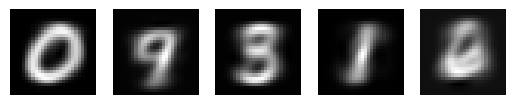

In [125]:
for i, centroid in enumerate(centroids):
    plt.subplot(1, k, i + 1)
    plt.imshow(pca.inverse_transform(centroid).reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


#### Exercise 1 Part 2: Apply your k-means implementation to the MNIST dataset

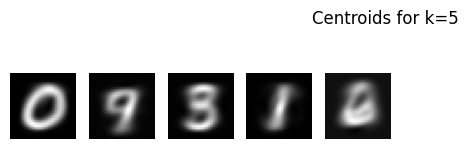

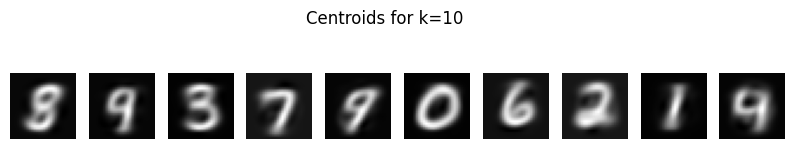

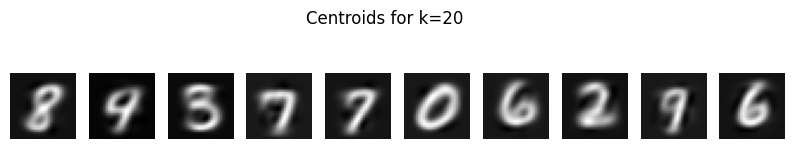

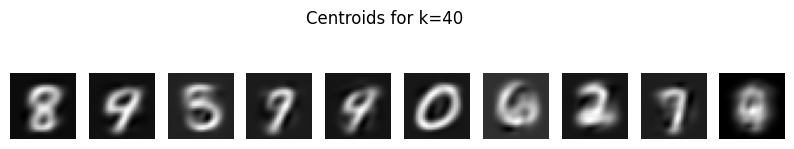

In [126]:
# Run K-means clustering for different values of k
k_values = [5, 10, 20, 40]
results = {}

for k in k_values:
    centroids, cluster_assignments = kmeans(X_reduced, k)
    results[k] = (centroids, cluster_assignments)

    plt.figure(figsize=(10, 2))
    for i, centroid in enumerate(centroids[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(pca.inverse_transform(centroid).reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Centroids for k={k}')
    plt.show()


#### Exercise 1 Part 3: Report the cluster consistency

In [127]:
# Calculate and report cluster consistency for each value of k
def cluster_consistency(X, cluster_assignments, k):
    consistencies = []
    for i in range(k):
        cluster_points = X[cluster_assignments == i]
        if len(cluster_points) == 0:
            consistencies.append(0)
            continue
        labels, counts = np.unique(cluster_points, return_counts=True)
        most_common_count = np.max(counts)
        consistency = most_common_count / len(cluster_points)
        consistencies.append(consistency)
    return np.mean(consistencies)

In [142]:
best_k = None
best_consistency = 0

for k in k_values:
    _, cluster_assignments = results[k]
    consistency = cluster_consistency(X_reduced, cluster_assignments, k)
    print(f'Cluster consistency for k={k}: {consistency:.4f}')
    if consistency > best_consistency:
        best_consistency = consistency
        best_k = k

print(f'Best k value: {best_k} with consistency: {best_consistency:.4f}')

Cluster consistency for k=5: 0.0001
Cluster consistency for k=10: 0.0002
Cluster consistency for k=20: 0.0003
Cluster consistency for k=40: 0.0006
Best k value: 40 with consistency: 0.0006


#### Exercise 1 Part 4: Which k value produces the best results?

Answer: Cluster consistency can be misleading as it does not consider the overall separation between clusters or the compactness of clusters. A high consistency might occur even if clusters are poorly separated, especially when k is large. The optimal value of k should balance between consistency and generalization, avoiding overfitting.

### Exercise 2: Gaussian Mixture Models (GMM) (10 pts)

#### Exercise 2 Part 1: Implement EM for GMM with diagonal covariance (Explaination added as comments)

In [129]:
def em_gmm_diagonal(X, k, max_iters=100, tolerance=1e-4, epsilon=1e-10):
    np.random.seed(42)  # For reproducibility
    n_samples, n_features = X.shape

    # Initialize the parameters
    weights = np.full(k, 1 / k)
    means = X[np.random.choice(n_samples, k, replace=False)]
    covariances = np.array([np.eye(n_features) for _ in range(k)])  # Diagonal covariance matrices

    log_likelihood = 0

    for iteration in range(max_iters):
        # E-step: Calculate responsibilities
        responsibilities = np.zeros((n_samples, k))
        for i in range(k):
            diff = X - means[i]
            exponent = -0.5 * np.sum((diff ** 2) / (np.diag(covariances[i]) + epsilon), axis=1)
            responsibilities[:, i] = weights[i] * (1 / np.sqrt((2 * np.pi) ** n_features * np.prod(np.diag(covariances[i]) + epsilon))) * np.exp(exponent)
        
        responsibilities_sum = np.sum(responsibilities, axis=1, keepdims=True) + epsilon
        responsibilities /= responsibilities_sum

        # Replace any NaN or Inf values with a small epsilon
        responsibilities = np.nan_to_num(responsibilities, nan=epsilon, posinf=epsilon, neginf=epsilon)

        # M-step: Update parameters
        effective_n = np.sum(responsibilities, axis=0)
        weights = effective_n / n_samples
        means = np.dot(responsibilities.T, X) / (effective_n[:, np.newaxis] + epsilon)
        for i in range(k):
            diff = X - means[i]
            covariances[i] = np.diag(np.dot(responsibilities[:, i] * diff.T, diff) / (effective_n[i] + epsilon))

        # Calculate log-likelihood
        new_log_likelihood = np.sum(np.log(responsibilities_sum + epsilon))
        if np.abs(new_log_likelihood - log_likelihood) < tolerance:
            break
        log_likelihood = new_log_likelihood

    return weights, means, covariances


In [130]:
k = 5
weights, means, covariances = em_gmm_diagonal(X_reduced, k)
print(f'EM for GMM with k={k} completed.')


EM for GMM with k=5 completed.


#### Exercise 2 Part 2: Apply GMM to classify the MNIST dataset using Bayes classifier

In [131]:
from scipy.stats import multivariate_normal

In [132]:
def bayes_classifier(X, weights, means, covariances, k, epsilon=1e-10):
    n_samples = X.shape[0]
    log_probabilities = np.zeros((n_samples, k))

    for i in range(k):
        cov_matrix = np.diag(covariances[i]) + epsilon * np.eye(len(covariances[i]))  
        rv = multivariate_normal(mean=means[i], cov=np.diag(covariances[i]) + epsilon)
        log_probabilities[:, i] = np.log(weights[i] + epsilon) + rv.logpdf(X)

    log_probabilities = np.nan_to_num(log_probabilities, nan=epsilon, posinf=epsilon, neginf=epsilon)

    return np.argmax(log_probabilities, axis=1)


In [133]:
predictions = bayes_classifier(X_reduced, weights, means, covariances, k)

In [134]:
from sklearn.metrics import accuracy_score

In [135]:
true_labels = mnist.target.astype(int)
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy of the Bayes classifier using GMM: {accuracy:.4f}')


Accuracy of the Bayes classifier using GMM: 0.0863


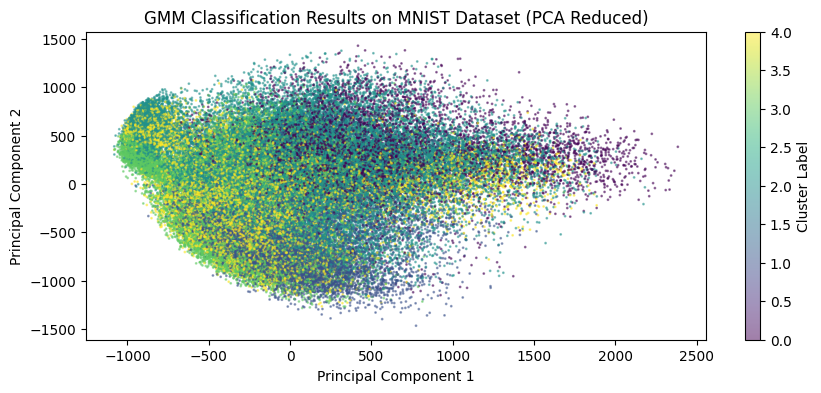

In [136]:
plt.figure(figsize=(10, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=predictions, cmap='viridis', s=1, alpha=0.5)
plt.title('GMM Classification Results on MNIST Dataset (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


#### Exercise 2 Part 2 Extra: Do you think this will be true for harder classification problems?

Extra: Solving harder classification problems, like indoor scene classification, through density estimation is often not ideal because estimating the full density function is a much more challenging task than directly learning decision boundaries. Density estimation requires modeling complex, high-dimensional distributions, which may lead to significant errors and overfitting, especially with limited data. In contrast, discriminative models focus directly on the decision boundary, often resulting in better generalization and accuracy for complex tasks.

#### Exercise 2, part 3:  Redo Ex 2.1 where we fit d GMMs (each with K components) to each feature dimension, component-wise GMM 

In [137]:
def cGMM_em(X, k, max_iters=100, tolerance=1e-4, epsilon=1e-10):
    np.random.seed(42)  
    n_samples, n_features = X.shape

    weights = np.full(k, 1 / k)
    means = X[np.random.choice(n_samples, k, replace=False)]
    covariances = np.array([np.var(X, axis=0) for _ in range(k)])  

    log_likelihood = 0

    for iteration in range(max_iters):
        responsibilities = np.zeros((n_samples, k))
        for i in range(k):
            diff = X - means[i]
            exponent = -0.5 * np.sum((diff ** 2) / (covariances[i] + epsilon), axis=1)
            responsibilities[:, i] = weights[i] * (1 / np.sqrt((2 * np.pi) ** n_features * np.prod(covariances[i] + epsilon))) * np.exp(exponent)
        responsibilities_sum = np.sum(responsibilities, axis=1, keepdims=True) + epsilon
        responsibilities /= responsibilities_sum

        responsibilities = np.nan_to_num(responsibilities, nan=epsilon, posinf=epsilon, neginf=epsilon)

        effective_n = np.sum(responsibilities, axis=0)
        weights = effective_n / n_samples
        means = np.dot(responsibilities.T, X) / (effective_n[:, np.newaxis] + epsilon)
        for i in range(k):
            diff = X - means[i]
            covariances[i] = np.sum(responsibilities[:, i][:, np.newaxis] * (diff ** 2), axis=0) / (effective_n[i] + epsilon)

        new_log_likelihood = np.sum(np.log(responsibilities_sum + epsilon))
        if np.abs(new_log_likelihood - log_likelihood) < tolerance:
            break
        log_likelihood = new_log_likelihood

    return weights, means, covariances

In [138]:
# Apply cGMM to the MNIST dataset
k = 10
weights, means, covariances = cGMM_em(X_reduced, k)
print(f'cGMM for k={k} completed.')

cGMM for k=10 completed.


In [139]:
def bayes_classifier_2(X, weights, means, covariances, k, epsilon=1e-6):
    n_samples = X.shape[0]
    log_probabilities = np.zeros((n_samples, k))

    for i in range(k):
        cov_matrix = np.diag(covariances[i]) + epsilon * np.eye(len(covariances[i]))  
        rv = multivariate_normal(mean=means[i], cov=cov_matrix, allow_singular=True)
        log_probabilities[:, i] = np.log(weights[i] + epsilon) + rv.logpdf(X)

    log_probabilities = np.nan_to_num(log_probabilities, nan=epsilon, posinf=epsilon, neginf=epsilon)

    return np.argmax(log_probabilities, axis=1)


In [140]:
cluster_assignments = bayes_classifier_2(X_reduced, weights, means, covariances, k)

In [143]:
true_labels = mnist.target.astype(int)
accuracy = accuracy_score(true_labels, cluster_assignments)
print(f'Accuracy of the Bayes classifier using cGMM: {accuracy:.4f}')

Accuracy of the Bayes classifier using cGMM: 0.0366


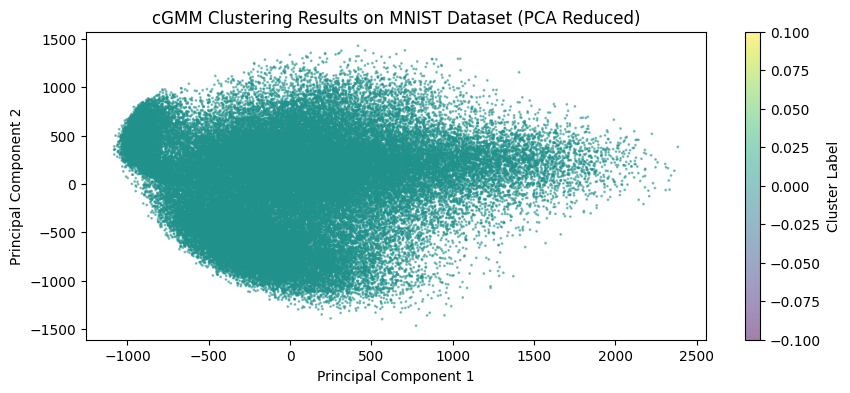

In [141]:
plt.figure(figsize=(10, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_assignments, cmap='viridis', s=1, alpha=0.5)
plt.title('cGMM Clustering Results on MNIST Dataset (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
